## <center>Decoding Excellence: A Data Analysis of Nobel Laureates  </center>
#### <center> (Nobel Prizes are awarded in the fields of Physics, Chemistry, Physiology or Medicine, Literature, and Peace) </center>

<b>Notes:    </b>

Motivation -  
Workflow  
I collected the data throught the public API of nobel laureates.org from the year 1901 to 2023, and  did all the initial data wrangling? in the jupyter notebook

Data gives you direction, data gives you ideas and is important for any economic policies

STREAMLIT FILTERS

1. category
2. gender

STREAMLIT  
 KPIs
- number of organizations, 
- individuals  and collaborations
- total number of winners,
- avg age of men and women 

In [713]:
pip install pycountry-convert

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.3.2 -> 24.0
[notice] To update, run: python.exe -m pip install --upgrade pip


In [714]:
import requests
from datetime import datetime, timedelta
import calendar
import pandas as pd
import numpy as np
import time
import json
import re
from io import StringIO
import plotly.express as px
import matplotlib.pyplot as plt
import nltk
from nltk.corpus import stopwords
import plotly.graph_objects as go

# https://nobelprize.readme.io/reference/laureate
# https://nobelprize.readme.io/reference/getting-started

### 1. Data Collection - through public API

In [715]:
#url = "https://api.nobelprize.org/2.1/laureates"
# json_raw = response.json()
# nobel_list_json = json_raw["laureates"]
# df = pd.DataFrame().from_dict(nobel_list_json)
# df.head()

# laureates.loc[laureates['country_of_birth'].isnull()]
# laureates_df[laureates_df.eq('Hans').any(axis=1)]

In [716]:
url = "http://api.nobelprize.org/v1/laureate.csv?gender=All"
headers = {"accept": "application/json"}
response = requests.get(url, headers=headers)
df = pd.read_csv(StringIO(response.text))


In [717]:
df.shape

(1000, 20)

In [718]:
df.head()

id       firstname    surname        born        died  \
0   1  Wilhelm Conrad    Röntgen  1845-03-27  1923-02-10   
1   2      Hendrik A.    Lorentz  1853-07-18  1928-02-04   
2   3          Pieter     Zeeman  1865-05-25  1943-10-09   
3   4           Henri  Becquerel  1852-12-15  1908-08-25   
4   5          Pierre      Curie  1859-05-15  1906-04-19   

             bornCountry bornCountryCode                bornCity  \
0  Prussia (now Germany)              DE  Lennep (now Remscheid)   
1        the Netherlands              NL                  Arnhem   
2        the Netherlands              NL              Zonnemaire   
3                 France              FR                   Paris   
4                 France              FR                   Paris   

       diedCountry diedCountryCode   diedCity gender  year category  \
0          Germany              DE     Munich   male  1901  physics   
1  the Netherlands              NL        NaN   male  1902  physics   
2  the Netherlands              NL  Amsterdam   male  1902  physics   
3           France              FR        NaN   male  1903  physics   
4           France              FR      Paris   male  1903  physics   

  overallMotivation  share  \
0               NaN      1   
1               NaN      2   
2               NaN      2   
3               NaN      2   
4               NaN      4   

                                                                                                                                                       motivation  \
0                             "in recognition of the extraordinary services he has rendered by the discovery of the remarkable rays subsequently named after him"   
1                        "in recognition of the extraordinary service they rendered by their researches into the influence of magnetism upon radiation phenomena"   
2                        "in recognition of the extraordinary service they rendered by their researches into the influence of magnetism upon radiation phenomena"   
3                                                    "in recognition of the extraordinary services he has rendered by his discovery of spontaneous radioactivity"   
4  "in recognition of the extraordinary services they have rendered by their joint researches on the radiation phenomena discovered by Professor Henri Becquerel"   

                                                                                                             name  \
0                                                                                               Munich University   
1                                                                                               Leiden University   
2                                                                                            Amsterdam University   
3                                                                                             École Polytechnique   
4  École municipale de physique et de chimie industrielles (Municipal School of Industrial Physics and Chemistry)   

        city          country  
0     Munich          Germany  
1     Leiden  the Netherlands  
2  Amsterdam  the Netherlands  
3      Paris           France  
4      Paris           France

### 2. Data Preprocessing

#### 2.1 Handling Missing Values and standardisation of formats, new features

In [719]:
# Columns with null values
df.isnull().sum()

id                     0
firstname              0
surname               32
born                   1
died                   0
bornCountry           31
bornCountryCode       31
bornCity              33
diedCountry          343
diedCountryCode      343
diedCity             349
gender                 0
year                   0
category               0
overallMotivation    977
share                  0
motivation             0
name                 264
city                 269
country              267
dtype: int64

<Axes: >

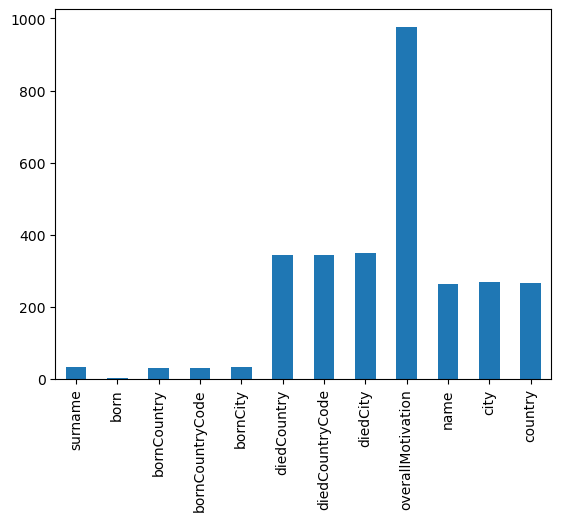

In [720]:
df.isna().sum()[df.isna().sum()>0].plot(kind='bar')

1. The column overallMotivation seems to be missing values intentionally and can be considered optional due to the presence of the column motivation. Furthermore 97.7% pf the values are missing from this column hence we can choose to drop this column altogether.
2. Since the columns id, bornCountryCode and diedCountryCode do not add any meaningful value to our analysis, given that we have the names of the countries they were born and died, these 3 columns can also be dropped.

In [721]:
cols_to_drop = [
      "id",
      "bornCountryCode",
      "diedCountryCode",
      "overallMotivation"]
laureates = df.drop(columns=cols_to_drop).copy()

In [722]:
# renaming columns
column_mapping = {'born': 'DOB', 
                  'died': 'DOD', 
                  'bornCountry': 'country_of_birth', 
                  'bornCity':'city_of_birth',
                  'diedCountry': 'country_of_death',
                  'diedCity':'city_of_demise',
                  'year':'year_of_award',
                  'share':'award_shared_with',
                  'name' : 'Institute'
                  #'category': 'category'
                 }
laureates.rename(columns=column_mapping, inplace=True)

In [723]:
print("Total number of nobel award prize winners:", laureates.shape[0])

Total number of nobel award prize winners: 1000


In [724]:
# organizations awarded nobel prize
organisations = laureates.loc[laureates['gender'] == 'org']
print("Nuumber of organizations that won nobel prize:", organisations.shape[0])

Nuumber of organizations that won nobel prize: 30


In [725]:
# people awarded nobel prize
laureates = laureates[laureates.gender != 'org']
print("Nuumber of people that won nobel prize:", laureates.shape[0])

Nuumber of people that won nobel prize: 970


In [726]:
laureates.isnull().sum()

firstname              0
surname                2
DOB                    0
DOD                    0
country_of_birth       1
city_of_birth          3
country_of_death     313
city_of_demise       319
gender                 0
year_of_award          0
category               0
award_shared_with      0
motivation             0
Institute            234
city                 239
country              237
dtype: int64

In [727]:
# filling in missing values
laureates.loc[laureates['firstname'] == "Abdulrazak", 'country_of_birth'] = "Tanzania"
laureates.loc[laureates['firstname'] == "Abdulrazak", 'city_of_birth'] = "Sultanate of Zanzibar"
laureates.loc[laureates['surname'] == "Whittingham", 'city_of_birth'] = "Nottingham"

In [728]:
old_countries = laureates[laureates["country_of_birth"].str.contains("now")]
old_countries.shape

(114, 16)

In [729]:
laureates = laureates[~laureates.country_of_birth.str.contains("now")]
laureates.shape

(856, 16)

In [730]:
old_countries_copy = old_countries.copy()
old_countries_copy["cob"] = old_countries_copy.country_of_birth.str.extract(r'\s(\w+)(?=\))',
                                     expand = True)
old_countries_copy.shape
old_countries_copy = old_countries_copy.drop(columns=['country_of_birth'])
old_countries = old_countries_copy.rename(columns={'cob':'country_of_birth'})
old_countries.shape

(114, 16)

In [731]:
data_you_need = [laureates, old_countries]
laureates_df = pd.concat(data_you_need, ignore_index=True)
laureates_df.shape

(970, 16)

In [732]:
laureates_df.isnull().sum()

firstname              0
surname                2
DOB                    0
DOD                    0
country_of_birth       0
city_of_birth          1
country_of_death     313
city_of_demise       319
gender                 0
year_of_award          0
category               0
award_shared_with      0
motivation             0
Institute            234
city                 239
country              237
dtype: int64

In [733]:
laureates_df.dtypes

firstname            object
surname              object
DOB                  object
DOD                  object
country_of_birth     object
city_of_birth        object
country_of_death     object
city_of_demise       object
gender               object
year_of_award         int64
category             object
award_shared_with     int64
motivation           object
Institute            object
city                 object
country              object
dtype: object

In [734]:
#laureates_df['DOB'] = pd.to_datetime(laureates_df['DOB'], format="%Y-%m-%d", errors='coerce')
#laureates_df['year_of_award'] = pd.to_datetime(laureates_df['year_of_award'])
#laureates_df['year_of_birth'] = pd.to_datetime(laureates_df['DOB']).dt.strftime('%Y')
laureates_df['year_of_birth'] = laureates_df['DOB'].str[:4]
laureates_df['month_of_birth'] = laureates_df['DOB'].str[5:7]
laureates_df['year_of_birth'] = laureates_df['year_of_birth'].astype('int')
laureates_df['month_of_birth'] = laureates_df['month_of_birth'].astype('int')

In [735]:
laureates_df.isnull().sum()

firstname              0
surname                2
DOB                    0
DOD                    0
country_of_birth       0
city_of_birth          1
country_of_death     313
city_of_demise       319
gender                 0
year_of_award          0
category               0
award_shared_with      0
motivation             0
Institute            234
city                 239
country              237
year_of_birth          0
month_of_birth         0
dtype: int64

In [736]:
laureates_df['awarded_age'] =  laureates_df['year_of_award'] - laureates_df['year_of_birth']
laureates_df['month_of_birth']  = laureates_df['month_of_birth'] .apply(lambda x: calendar.month_abbr[x])

In [737]:
laureates_df.loc[laureates_df['Institute'].str.contains('Planck', na=False), 'institute'] = 'Max-Planck-Institut'
laureates_df.loc[laureates_df['city_of_birth'] == 'Prague', 'country_of_birth'] = 'Czech Republic'
laureates_df.loc[laureates_df['city_of_birth'] == 'Plzen', 'country_of_birth'] = 'Germany'

In [738]:
category_mapping = {'physics': 'Physics', 'chemistry': 'Chemistry', 'medicine': 'Medicine', 
                    'literature': 'Literature', 'peace': 'Peace', 'economics': 'Economics'}
laureates_df['category'] = laureates_df['category'].replace(category_mapping)

In [742]:
laureates_df = laureates_df.replace({
    'country_of_birth': {
        'the Netherlands': 'Netherlands',
        'Scotland': 'United Kingdom',
        'Faroe Islands (Denmark)': 'Denmark',
        'Northern Ireland': 'United Kingdom',
        'East Timor': 'Indonesia',
        'Guadeloupe Island': 'France',
        'Herzegovina': 'Bosnia and Herzegovina',
        'Korea': 'South Korea',
        'Lucia':'Saint Lucia' 
    }
})

In [743]:
def country_to_continent(country_name):
    country_alpha2 = pc.country_name_to_country_alpha2(country_name)
    country_continent_code = pc.country_alpha2_to_continent_code(country_alpha2)
    country_continent_name = pc.convert_continent_code_to_continent_name(country_continent_code)
    return country_continent_name
laureates_df['continent'] = laureates_df['country_of_birth'].apply(country_to_continent)

#### Average age calculation

In [744]:
period_length = 10
start_year = 1900
end_year = 2031
final_end = end_year 

In [745]:
starts = np.arange(start_year, end_year, period_length).tolist()

year_range = end_year - start_year
modulo = year_range % period_length

if modulo == 0:
    final_start = end_year - period_length
else:
    final_start = end_year - 2
final_end = end_year 


tuples = [(start, start+period_length) for start in starts]
# We'll add the last period calculated earlier
tuples.append(tuple([final_start, final_end]))
bins = pd.IntervalIndex.from_tuples(tuples, closed='left')
print(bins)


original_labels = list(bins.astype(str))
new_labels = ['{} - {}'.format(b.strip('[)').split(', ')[0], int(b.strip('[)').split(', ')[1])-1) for b in original_labels]
label_dict = dict(zip(original_labels, new_labels))
labels = list(label_dict.values())
labels = labels[:-2]  
print(labels)

laureates_df['period'] = pd.cut(laureates_df['year_of_award'], bins=starts, labels=labels)

IntervalIndex([[1900, 1910), [1910, 1920), [1920, 1930), [1930, 1940), [1940, 1950) ... [2000, 2010), [2010, 2020), [2020, 2030), [2030, 2040), [2029, 2031)], dtype='interval[int64, left]')
['1900 - 1909', '1910 - 1919', '1920 - 1929', '1930 - 1939', '1940 - 1949', '1950 - 1959', '1960 - 1969', '1970 - 1979', '1980 - 1989', '1990 - 1999', '2000 - 2009', '2010 - 2019', '2020 - 2029']


In [750]:
avg_age

period    category  awarded_age
0   1900 - 1909   Chemistry    52.200000
1   1900 - 1909   Economics          NaN
2   1900 - 1909  Literature    66.272727
3   1900 - 1909    Medicine    56.083333
4   1900 - 1909       Peace    67.307692
5   1900 - 1909     Physics    50.928571
6   1910 - 1919   Chemistry    48.125000
7   1910 - 1919   Economics          NaN
8   1910 - 1919  Literature    56.888889
9   1910 - 1919    Medicine    47.333333
10  1910 - 1919       Peace    63.000000
11  1910 - 1919     Physics    46.700000
12  1920 - 1929   Chemistry    51.600000
13  1920 - 1929   Economics          NaN
14  1920 - 1929  Literature    58.500000
15  1920 - 1929    Medicine    55.363636
16  1920 - 1929       Peace    63.636364
17  1920 - 1929     Physics    44.166667
18  1930 - 1939   Chemistry    45.750000
19  1930 - 1939   Economics          NaN
20  1930 - 1939  Literature    57.875000
21  1930 - 1939    Medicine    54.153846
22  1930 - 1939       Peace    64.142857
23  1930 - 1939     Physics    41.200000
24  1940 - 1949   Chemistry    55.636364
25  1940 - 1949   Economics          NaN
26  1940 - 1949  Literature    66.285714
27  1940 - 1949    Medicine    56.176471
28  1940 - 1949       Peace    69.800000
29  1940 - 1949     Physics    50.625000
30  1950 - 1959   Chemistry    51.692308
31  1950 - 1959   Economics          NaN
32  1950 - 1959  Literature    63.200000
33  1950 - 1959    Medicine    51.105263
34  1950 - 1959       Peace    66.000000
35  1950 - 1959     Physics    49.150000
36  1960 - 1969   Chemistry    56.600000
37  1960 - 1969   Economics    65.000000
38  1960 - 1969  Literature    65.090909
39  1960 - 1969    Medicine    55.807692
40  1960 - 1969       Peace    57.800000
41  1960 - 1969     Physics    52.666667
42  1970 - 1979   Chemistry    60.529412
43  1970 - 1979   Economics    67.333333
44  1970 - 1979  Literature    68.818182
45  1970 - 1979    Medicine    57.480000
46  1970 - 1979       Peace    56.250000
47  1970 - 1979     Physics    52.840000
48  1980 - 1989   Chemistry    56.789474
49  1980 - 1989   Economics    67.083333
50  1980 - 1989  Literature    68.300000
51  1980 - 1989    Medicine    60.772727
52  1980 - 1989       Peace    57.750000
53  1980 - 1989     Physics    60.260870
54  1990 - 1999   Chemistry    63.750000
55  1990 - 1999   Economics    65.375000
56  1990 - 1999  Literature    65.900000
57  1990 - 1999    Medicine    61.476190
58  1990 - 1999       Peace    59.857143
59  1990 - 1999     Physics    61.590909
60  2000 - 2009   Chemistry    66.280000
61  2000 - 2009   Economics    67.666667
62  2000 - 2009  Literature    67.800000
63  2000 - 2009    Medicine    63.083333
64  2000 - 2009       Peace    62.300000
65  2000 - 2009     Physics    66.185185
66  2010 - 2019   Chemistry    69.038462
67  2010 - 2019   Economics    67.473684
68  2010 - 2019  Literature    70.200000
69  2010 - 2019    Medicine    68.423077
70  2010 - 2019       Peace    46.333333
71  2010 - 2019     Physics    69.777778
72  2020 - 2029   Chemistry    66.375000
73  2020 - 2029   Economics    66.571429
74  2020 - 2029  Literature    73.000000
75  2020 - 2029    Medicine    63.800000
76  2020 - 2029       Peace    57.250000
77  2020 - 2029     Physics    77.000000

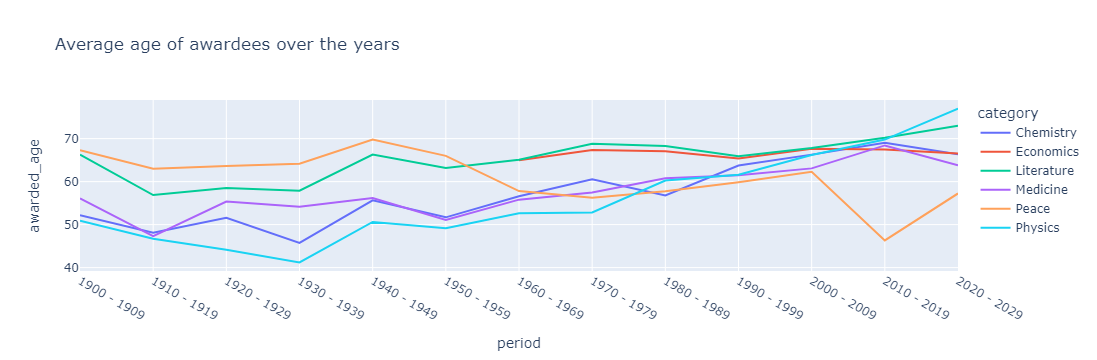

In [746]:
avg_age = laureates_df.groupby(['period', 'category'])['awarded_age'].mean().reset_index()
fig = px.line(avg_age, x="period", y="awarded_age", color='category', title='Average age of awardees over the years')
fig.show()

In [751]:
laureates_df.columns

Index(['firstname', 'surname', 'DOB', 'DOD', 'country_of_birth',
       'city_of_birth', 'country_of_death', 'city_of_demise', 'gender',
       'year_of_award', 'category', 'award_shared_with', 'motivation',
       'Institute', 'city', 'country', 'year_of_birth', 'month_of_birth',
       'awarded_age', 'institute', 'continent', 'period'],
      dtype='object')

In [748]:
laureates_df.to_csv('nobel_laureates.csv', index=False)

In [749]:
organisations.to_csv('organisations.csv', index=False)

### 3. Exploratory Data Analysis

In [312]:
# Create basic choropleth map
recipient_countries = laureates_df.groupby(['country_of_birth'])['country_of_birth'].count().reset_index(name="count")
recipient_countries

country_of_birth  count
0                   Algeria      2
1                 Argentina      4
2                 Australia     10
3                   Austria     19
4                Azerbaijan      1
5                Bangladesh      1
6                   Belarus      4
7                   Belgium      9
8                    Brazil      1
9                  Bulgaria      1
10                   Canada     21
11                    Chile      2
12                    China     12
13                 Colombia      2
14                    Congo      1
15               Costa Rica      1
16                  Croatia      1
17                   Cyprus      1
18                  Denmark     12
19               East Timor      2
20                    Egypt      6
21                 Ethiopia      1
22  Faroe Islands (Denmark)      1
23                  Finland      5
24                   France     61
25                  Germany     84
26                    Ghana      1
27                   Greece      1
28        Guadeloupe Island      1
29                Guatemala      2
30              Herzegovina      2
31                  Hungary     11
32                  Iceland      1
33                    India      9
34                Indonesia      1
35                     Iran      3
36                     Iraq      1
37                  Ireland      5
38                   Israel      6
39                    Italy     20
40                    Japan     28
41                    Kenya      1
42                    Korea      2
43                   Latvia      1
44                  Lebanon      1
45                  Liberia      2
46                Lithuania      3
47                    Lucia      1
48               Luxembourg      2
49                Macedonia      1
50               Madagascar      1
51                   Mexico      3
52                  Morocco      1
53                  Myanmar      1
54              New Zealand      3
55                  Nigeria      1
56         Northern Ireland      5
57                   Norway     13
58                 Pakistan      3
59                     Peru      1
60              Philippines      1
61                   Poland     29
62                 Portugal      2
63                 Republic      6
64                  Romania      4
65                   Russia     29
66              Saint Lucia      1
67                 Scotland     11
68                 Slovakia      1
69                 Slovenia      1
70             South Africa      9
71                    Spain      7
72                   Sweden     30
73              Switzerland     19
74                   Taiwan      1
75                 Tanzania      1
76      Trinidad and Tobago      1
77                  Tunisia      1
78                   Turkey      3
79                      USA    292
80                  Ukraine      5
81           United Kingdom     90
82                Venezuela      1
83                  Vietnam      1
84                    Yemen      1
85                 Zimbabwe      1
86          the Netherlands     19

#### 3.1 Geographical Distribution

In [313]:
custom_purple_scale = ['#746969', '#66a9c2', '#249fcd', '#ff9b2f', '#fc8300', '#ffd92f'  ]

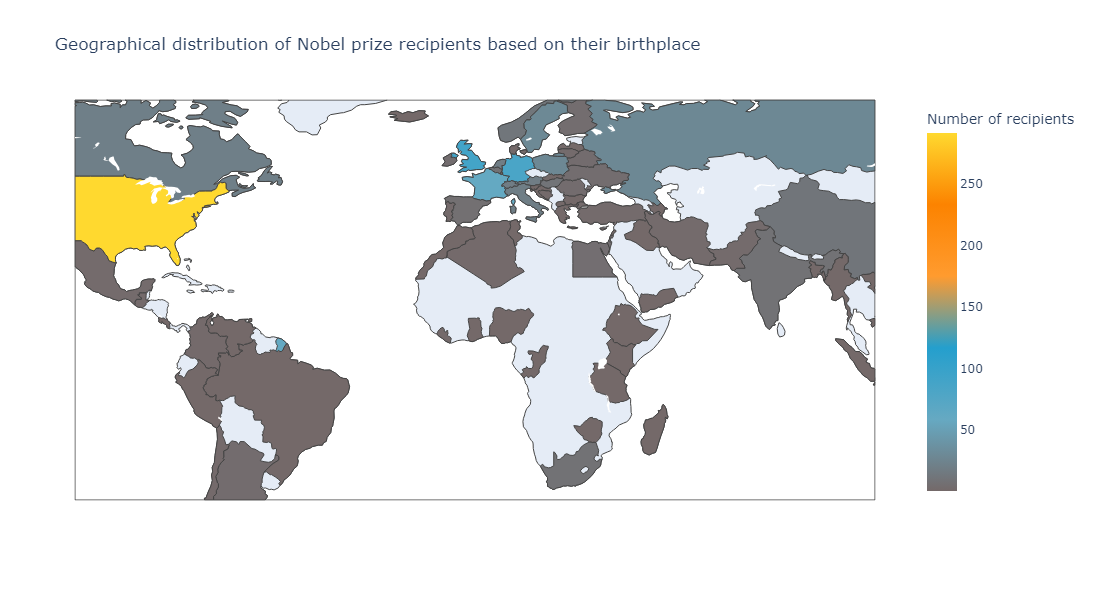

In [314]:
fig1 = px.choropleth(recipient_countries, locations='country_of_birth', 
                    color='count', 
                    hover_name='country_of_birth',
                    color_continuous_scale=custom_purple_scale, 
                    locationmode='country names', 
                    title='Geographical distribution of Nobel prize recipients based on their birthplace',
                    labels={'count': 'Number of recipients',
                          'country_of_birth': 'Country'})

fig1.update_layout(
    autosize=False,
    width=800,
    height=600,
    margin=dict(
        l=50,
        r=50,
        b=100,
        t=100,
        pad=4
    )
)
fig1.show()

In [315]:
# Countries of origin for the most Nobel laureates
top10countries = recipient_countries.sort_values(by='count', ascending=False).head(10)
top10countries

country_of_birth  count
79              USA    292
81   United Kingdom     90
25          Germany     84
24           France     61
72           Sweden     30
61           Poland     29
65           Russia     29
40            Japan     28
10           Canada     21
39            Italy     20

#### 3.2 Gender Analysis

1. Male, female ratio
2. Average age of the recipient based on gender
3. Youngest and oldest recipient


In [316]:
gender_ratio = laureates_df['gender'].value_counts(normalize=True)
gender_ratio

gender
male      0.93299
female    0.06701
Name: proportion, dtype: float64

In [317]:
# gender ratio
gender_ratio = laureates_df['gender'].value_counts().reset_index(name="count")
gender_ratio

gender  count
0    male    905
1  female     65

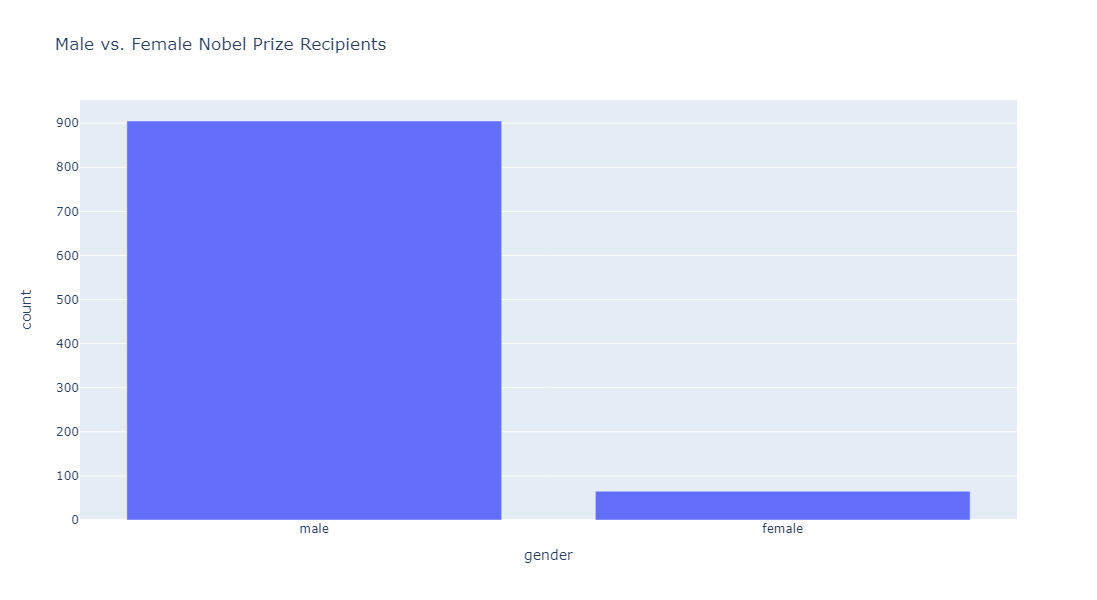

In [318]:
fig2 = px.bar(gender_ratio, x="gender", y="count", title="Male vs. Female Nobel Prize Recipients")

fig2.update_layout(
    autosize=False,
    width=600,
    height=600,
)
fig2.show()

In [319]:
# average age of recipient based on gender
age = laureates_df.groupby(['gender'])['awarded_age'].mean().round(0).reset_index(name="avg_age")
age

gender  avg_age
0  female     58.0
1    male     60.0

In [320]:
# youngest woman and first woman

youngest_woman = laureates_df.sort_values(by=['gender','awarded_age']).head(1)
first_woman= laureates_df.sort_values(by='year_of_award')
first_woman = first_woman[first_woman['gender'] == 'female'].iloc[0]
first_woman

firstname                                                                                                                                                                     Marie
surname                                                                                                                                                                       Curie
DOB                                                                                                                                                                      1867-11-07
DOD                                                                                                                                                                      1934-07-04
country_of_birth                                                                                                                                                             Poland
city_of_birth                                                                                       

In [321]:
# top 3 youngest and oldest nobel prize winners
youngest = laureates_df.sort_values(by='awarded_age').head(3)
oldest = laureates_df.sort_values(by='awarded_age').tail(3)

# print the results
print("3 youngest Nobel Laureates:")
print(youngest[['firstname', 'surname', 'category' ,'awarded_age']])

print("3 oldest Nobel Laureates:")
print(oldest[['firstname', 'surname', 'category' ,'awarded_age']])

3 youngest Nobel Laureates:
    firstname    surname Category  awarded_age
753    Malala  Yousafzai    Peace           17
795     Nadia      Murad    Peace           25
13   Lawrence      Bragg  Physics           25
3 oldest Nobel Laureates:
    firstname     surname   Category  awarded_age
672    Leonid     Hurwicz  Economics           90
789    Arthur      Ashkin    Physics           96
804      John  Goodenough  Chemistry           97


In [322]:
gen_cat = laureates_df.groupby(['category', 'gender']).size().reset_index(name="count")
gen_cat

Category  gender  count
0    Chemistry  female      8
1    Chemistry    male    186
2    Economics  female      3
3    Economics    male     90
4   Literature  female     17
5   Literature    male    103
6     Medicine  female     13
7     Medicine    male    214
8        Peace  female     19
9        Peace    male     92
10     Physics  female      5
11     Physics    male    220

In [545]:
gen_year = laureates_df.groupby(['gender', 'year_of_award']).size().reset_index(name="count")
duplicated_years = gen_year[gen_year.duplicated('year_of_award', keep=False)]
duplicated_years

gender  year_of_award  count
0    female           1903      1
1    female           1905      1
2    female           1909      1
3    female           1911      1
4    female           1926      1
5    female           1928      1
6    female           1931      1
7    female           1935      1
8    female           1938      1
9    female           1945      1
10   female           1946      1
11   female           1947      1
12   female           1963      1
13   female           1964      1
14   female           1966      1
15   female           1976      2
16   female           1977      1
17   female           1979      1
18   female           1982      1
19   female           1983      1
20   female           1986      1
21   female           1988      1
22   female           1991      2
23   female           1992      1
24   female           1993      1
25   female           1995      1
26   female           1996      1
27   female           1997      1
28   female           2003      1
29   female           2004      3
30   female           2007      1
31   female           2008      1
32   female           2009      5
33   female           2011      3
34   female           2013      1
35   female           2014      2
36   female           2015      2
37   female           2018      4
38   female           2019      1
39   female           2020      4
40   female           2021      1
41   female           2022      2
42   female           2023      4
45     male           1903      6
47     male           1905      4
51     male           1909      6
53     male           1911      5
68     male           1926      5
70     male           1928      3
73     male           1931      5
77     male           1935      4
80     male           1938      3
84     male           1945      6
85     male           1946      7
86     male           1947      5
102    male           1963      8
103    male           1964      7
105    male           1966      5
115    male           1976      7
116    male           1977      9
118    male           1979     10
121    male           1982      8
122    male           1983      6
125    male           1986     10
127    male           1988     10
130    male           1991      5
131    male           1992      6
132    male           1993     10
134    male           1995     10
135    male           1996     12
136    male           1997     10
142    male           2003     10
143    male           2004      9
146    male           2007     10
147    male           2008     11
148    male           2009      8
150    male           2011     10
152    male           2013     11
153    male           2014     11
154    male           2015      8
157    male           2018      9
158    male           2019     13
159    male           2020      7
160    male           2021     12
161    male           2022     10
162    male           2023      7

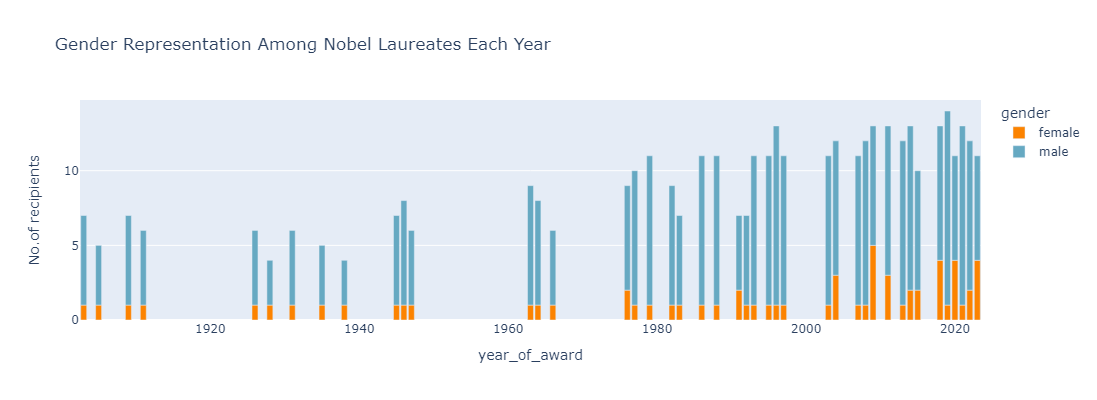

In [546]:
colours = {'male':'#66a9c2','female': '#fc8300' }
fig1a = px.bar(duplicated_years, x="year_of_award", y="count", color='gender',   
             height=400,
             title='Gender Representation Among Nobel Laureates Each Year',
             hover_data={"gender": False,
                         "count" : True},
             hover_name="gender",
             barmode='relative',  
             labels={'count': 'No.of recipients'},
             color_discrete_map=colours)
fig1a.show()

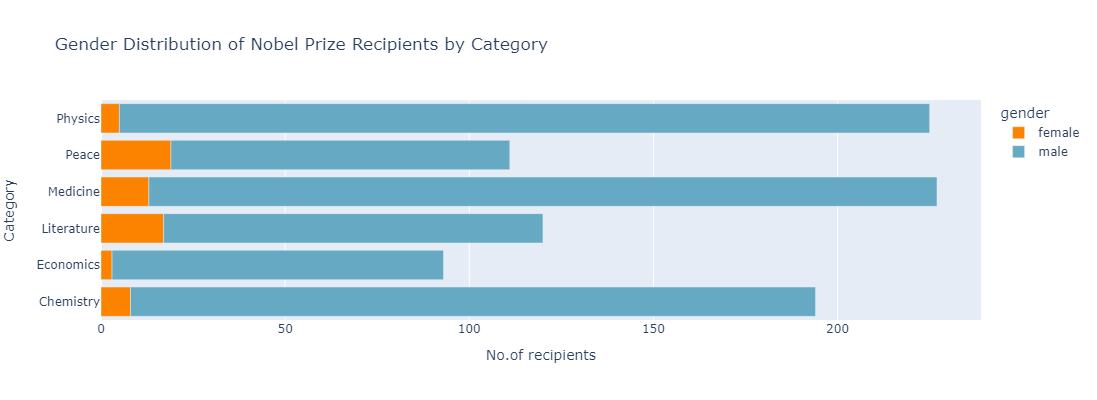

In [323]:
colours = {'male':'#66a9c2','female': '#fc8300' }
fig1 = px.bar(gen_cat, x="count", y="category", color='gender', orientation='h',      
             height=400,
             title='Gender Distribution of Nobel Prize Recipients by category',
             hover_data={"category": False, 
                         "gender": False,
                         "count" : True},
             hover_name="gender",
             labels={'count': 'No.of recipients'},
             color_discrete_map=colours)
fig1.show()

#### 3.3 Top 10 Institutions with the Highest Number of Nobel Prize Laureates

In [752]:
# university or institution with the most Nobel Prize recipients
institute = laureates_df['Institute'].value_counts().head(20).reset_index(name="count")
institute

Institute  count
0                       University of California     36
1                             Harvard University     28
2                            Stanford University     22
3    Massachusetts Institute of Technology (MIT)     22
4                          University of Chicago     19
5                            Columbia University     18
6                        University of Cambridge     17
7                           Princeton University     17
8   California Institute of Technology (Caltech)     17
9                         Rockefeller University     13
10           MRC Laboratory of Molecular Biology     10
11                          University of Oxford     10
12                               Yale University      8
13                            Cornell University      8
14                            University College      7
15                        Harvard Medical School      7
16                              Institut Pasteur      6
17                      University of Heidelberg      6
18                             Berlin University      6
19    Rockefeller Institute for Medical Research      6

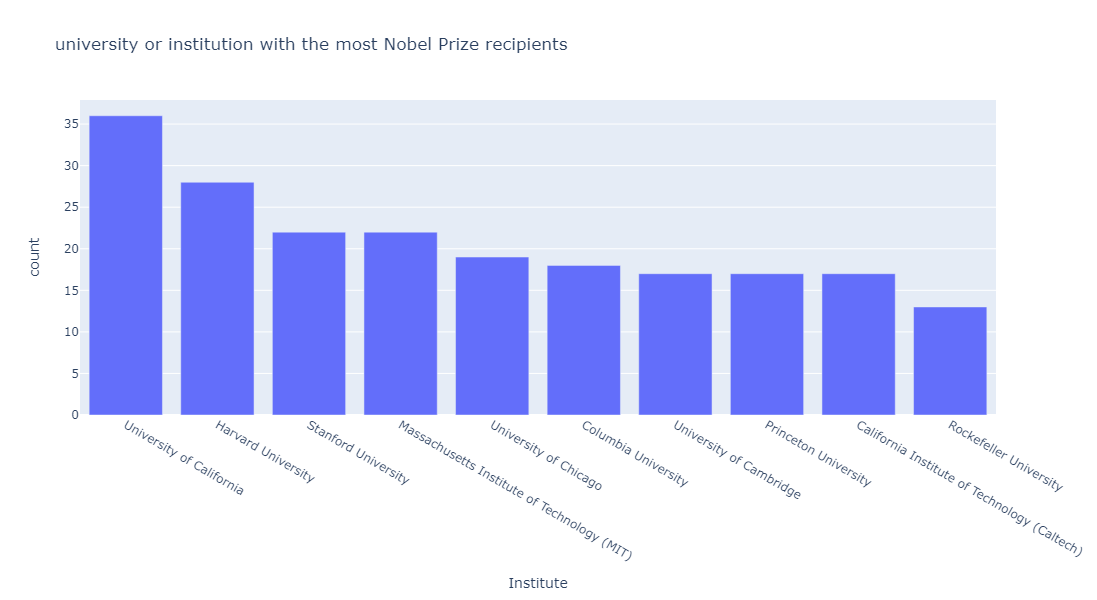

In [325]:
fig3 = px.bar(institute, x="Institute", y="count", title="university or institution with the most Nobel Prize recipients")

fig3.update_layout(
    autosize=False,
    width=600,
    height=600,
)
fig3.show()

#### 3.4 Organizations

In [326]:
org = organisations['firstname'].value_counts().reset_index(name="count")
org.columns = ['Name of Organisation', 'No of Awards']
org.to_csv('organisations.csv', index=False)
org

Name of Organisation  No of Awards
0                      International Committee of the Red Cross             3
1   Office of the United Nations High Commissioner for Refugees             2
2                                Institute of International Law             1
3                                       Doctors Without Borders             1
4                                                      Memorial             1
5                                          World Food Programme             1
6             International Campaign to Abolish Nuclear Weapons             1
7                                     National Dialogue Quartet             1
8          Organisation for the Prohibition of Chemical Weapons             1
9                                                European Union             1
10                    Intergovernmental Panel on Climate Change             1
11                                                 Grameen Bank             1
12                           International Atomic Energy Agency             1
13                                               United Nations             1
14             Pugwash Conferences on Science and World Affairs             1
15                      International Campaign to Ban Landmines             1
16                         Permanent International Peace Bureau             1
17                           United Nations Peacekeeping Forces             1
18   International Physicians for the Prevention of Nuclear War             1
19                                        Amnesty International             1
20                            International Labour Organization             1
21                               United Nations Children's Fund             1
22                                League of Red Cross Societies             1
23                           American Friends Service Committee             1
24                                      Friends Service Council             1
25                     Nansen International Office for Refugees             1
26                                   Center for Civil Liberties             1

#### 3.5 Peace Prize

#### 3.6 Invidual vs Shared Contribution

In [327]:
a = laureates_df['award_shared_with'].unique()
print(sorted(a))

[1, 2, 3, 4]


In [328]:
laureates_df.loc[laureates_df['award_shared_with'] == 4]

firstname         surname         DOB         DOD country_of_birth  \
3            Pierre           Curie  1859-05-15  1906-04-19           France   
66       J. Hans D.          Jensen  1907-06-25  1973-02-11          Germany   
68     Aleksandr M.       Prokhorov  1916-07-11  2002-01-08        Australia   
79              Leo           Esaki  1925-03-12  0000-00-00            Japan   
80             Ivar         Giaever  1929-04-05  0000-00-00           Norway   
92             Arno         Penzias  1933-04-26  2024-01-22          Germany   
93   Robert Woodrow          Wilson  1936-01-10  0000-00-00              USA   
98         Nicolaas     Bloembergen  1920-03-11  2017-09-05  the Netherlands   
99        Arthur L.        Schawlow  1921-05-05  1999-04-28              USA   
106        Heinrich          Rohrer  1933-06-06  2013-05-16      Switzerland   
112        Wolfgang            Paul  1913-08-10  1993-12-07          Germany   
162         John H.        Northrop  1891-07-05  1987-05-27              USA   
163      Wendell M.         Stanley  1904-08-16  1971-06-15              USA   
180       Frederick          Sanger  1918-08-13  2013-11-19   United Kingdom   
191     Ronald G.W.         Norrish  1897-11-09  1978-06-07   United Kingdom   
192          George          Porter  1920-12-06  2002-08-31   United Kingdom   
199        Stanford           Moore  1913-09-04  1982-08-23              USA   
200      William H.           Stein  1911-06-25  1980-02-02              USA   
211          Walter         Gilbert  1932-03-21  0000-00-00              USA   
239         Paul D.           Boyer  1918-07-31  2018-06-02              USA   
240         John E.          Walker  1941-01-07  0000-00-00   United Kingdom   
303          George          Beadle  1903-10-22  1989-06-09              USA   
304          Edward           Tatum  1909-12-14  1975-11-05              USA   
348           Roger       Guillemin  1924-01-11  2024-02-21           France   
359        David H.           Hubel  1926-02-27  2013-09-22           Canada   
360      Torsten N.          Wiesel  1924-06-03  0000-00-00           Sweden   
593         Herbert         Kroemer  1928-08-25  0000-00-00          Germany   
606         William         Knowles  1917-06-01  2012-06-13              USA   
607           Ryoji          Noyori  1938-09-03  0000-00-00            Japan   
617         Raymond       Davis Jr.  1914-10-14  2006-05-31              USA   
618       Masatoshi         Koshiba  1926-09-19  2020-11-12            Japan   
620         John B.            Fenn  1917-06-15  2010-12-10              USA   
621          Koichi          Tanaka  1959-08-03  0000-00-00            Japan   
650         John L.            Hall  1934-08-21  0000-00-00              USA   
651      Theodor W.          Hänsch  1941-10-30  0000-00-00          Germany   
676       Françoise  Barré-Sinoussi  1947-07-30  0000-00-00           France   
677             Luc      Montagnier  1932-08-18  2022-02-08           France   
679          Makoto       Kobayashi  1944-04-07  0000-00-00            Japan   
680       Toshihide         Maskawa  1940-02-07  2021-07-23            Japan   
691      Willard S.           Boyle  1924-08-19  2011-05-07           Canada   
692       George E.           Smith  1930-05-10  0000-00-00              USA   
710        Bruce A.         Beutler  1957-12-29  0000-00-00              USA   
711        Jules A.        Hoffmann  1941-08-02  0000-00-00       Luxembourg   
714        Brian P.         Schmidt  1967-02-24  0000-00-00              USA   
715         Adam G.           Riess  1969-12-16  0000-00-00              USA   
743       May-Britt           Moser  1963-01-04  0000-00-00           Norway   
744       Edvard I.           Moser  1962-04-27  0000-00-00           Norway   
755      William C.        Campbell  1930-06-28  0000-00-00          Ireland   
756         Satoshi           Ōmura  1935-07-12  0000-00-00            Japan   
767    F. 

In [329]:
contributors = laureates_df.groupby(['award_shared_with'])['award_shared_with'].count().reset_index(name="count")
collab_list=["Individual", "2 contributors", "3 contributors", "4 contributors"] 
contributors['awarded_to'] = collab_list
contributors.drop(['award_shared_with'], axis=1, inplace=True)
contributors

count      awarded_to
0    340      Individual
1    321  2 contributors
2    235  3 contributors
3     74  4 contributors

In [330]:
laureates_df.dtypes

firstname            object
surname              object
DOB                  object
DOD                  object
country_of_birth     object
city_of_birth        object
country_of_death     object
city_of_demise       object
gender               object
year_of_award         int64
Category             object
award_shared_with     int64
motivation           object
Institute            object
city                 object
country              object
year_of_birth         int32
month_of_birth       object
awarded_age           int64
institute            object
dtype: object

In [331]:
laureates_df.head(1)

firstname  surname         DOB         DOD country_of_birth city_of_birth  \
0  Hendrik A.  Lorentz  1853-07-18  1928-02-04  the Netherlands        Arnhem   

  country_of_death city_of_demise gender  year_of_award Category  \
0  the Netherlands            NaN   male           1902  Physics   

   award_shared_with  \
0                  2   

                                                                                                                                 motivation  \
0  "in recognition of the extraordinary service they rendered by their researches into the influence of magnetism upon radiation phenomena"   

           Institute    city          country  year_of_birth month_of_birth  \
0  Leiden University  Leiden  the Netherlands           1853            Jul   

   awarded_age institute  
0           49       NaN

In [332]:
sharing_cat = laureates_df.groupby(['category','award_shared_with']).size().reset_index(name = "count")
sharing_cat

Category  award_shared_with  count
0    Chemistry                  1     63
1    Chemistry                  2     58
2    Chemistry                  3     57
3    Chemistry                  4     16
4    Economics                  1     26
5    Economics                  2     41
6    Economics                  3     24
7    Economics                  4      2
8   Literature                  1    112
9   Literature                  2      8
10    Medicine                  1     40
11    Medicine                  2     78
12    Medicine                  3     93
13    Medicine                  4     16
14       Peace                  1     52
15       Peace                  2     52
16       Peace                  3      7
17     Physics                  1     47
18     Physics                  2     84
19     Physics                  3     54
20     Physics                  4     40

In [333]:
filtered_physics = sharing_cat[sharing_cat['category'] == 'Physics']

In [334]:
individual_contributors = contributors.loc[contributors['awarded_to'] == "Individual", 'count'].iloc[0]
print("Total number of nobel prize recipients for their individual contribution:", individual_contributors)

Total number of nobel prize recipients for their individual contribution: 340


In [335]:
collab_contributors = contributors.loc[contributors['awarded_to'] != "Individual", 'count'].sum()
print("Total number of nobel prize recipients for their collaborative contribution:", collab_contributors)

Total number of nobel prize recipients for their collaborative contribution: 630


In [336]:
cat = laureates_df['category'].unique()
print(sorted(cat))

['Chemistry', 'Economics', 'Literature', 'Medicine', 'Peace', 'Physics']


In [337]:
# number of awards won in each category
awards_per_category = df['category'].value_counts().reset_index(name="count")
awards_per_category

category  count
0    medicine    227
1     physics    225
2   chemistry    194
3       peace    141
4  literature    120
5   economics     93

In [338]:
# Two-time Nobel Prize winner
repeat_laureates = laureates_df[laureates_df.duplicated(subset=['firstname', 'surname'], keep=False)]
repeat_laureates

firstname    surname         DOB         DOD country_of_birth  \
54        John    Bardeen  1908-05-23  1991-01-30              USA   
55        John    Bardeen  1908-05-23  1991-01-30              USA   
173      Linus    Pauling  1901-02-28  1994-08-19              USA   
174      Linus    Pauling  1901-02-28  1994-08-19              USA   
179  Frederick     Sanger  1918-08-13  2013-11-19   United Kingdom   
180  Frederick     Sanger  1918-08-13  2013-11-19   United Kingdom   
608      Barry  Sharpless  1941-04-28  0000-00-00              USA   
609      Barry  Sharpless  1941-04-28  0000-00-00              USA   
857      Marie      Curie  1867-11-07  1934-07-04           Poland   
858      Marie      Curie  1867-11-07  1934-07-04           Poland   

       city_of_birth country_of_death city_of_demise  gender  year_of_award  \
54        Madison WI              USA      Boston MA    male           1956   
55        Madison WI              USA      Boston MA    male           1972   
173      Portland OR              USA     Big Sur CA    male           1962   
174      Portland OR              USA     Big Sur CA    male           1954   
179        Rendcombe   United Kingdom      Cambridge    male           1958   
180        Rendcombe   United Kingdom      Cambridge    male           1980   
608  Philadelphia PA              NaN            NaN    male           2001   
609  Philadelphia PA              NaN            NaN    male           2022   
857           Warsaw           France     Sallanches  female           1903   
858           Warsaw           France     Sallanches  female           1911   

      Category  award_shared_with  \
54     Physics                  3   
55     Physics                  3   
173      Peace                  1   
174  Chemistry                  1   
179  Chemistry                  1   
180  Chemistry                  4   
608  Chemistry                  2   
609  Chemistry                  3   
857    Physics                  4   
858  Chemistry                  1   

                                                                                                                                                                                                                motivation  \
54                                                                                                                                   "for their researches on semiconductors and their discovery of the transistor effect"   
55                                                                                                                                 "for their jointly developed theory of superconductivity usually called the BCS-theory"   
173                                                                                                                                                    "for his fight against the nuclear arms race between East and West"   
174                                                                                  "for his research into the nature of the chemical bond and its application to the elucidation of the structure of complex substances"   
179                                                                                                                                                 "for his work on the structure of proteins especially that of insulin"   
180                                                                                                                              "for their contributions concerning the determination of base sequences in nucleic acids"   
608                                                                                                                                                               "for his work on chirally catalysed oxidation reactions"   
609                                                                                                                                                   "for the development of click 

#### 3.7 Exploring Text Data of column motivation 
Unstructured data constitute about 80% of the data we produce

In [339]:
pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_rows', None)
research_topic = laureates_df[['firstname','category', 'motivation', 'year_of_award']].copy()


In [340]:
import numpy as np
import pandas as pd
from os import path
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

In [341]:
# create some custom stop words
custom_stop_words = {'discovery', 'discoveries', 'work', 'development', 'contribution','contributions', 'his', 'pioneering', 'recognition',
                    'concerning', 'determination', 'economic', 'chemistry', 'chemical', 'theory', 'analysis',
                    'studies', 'research', 'method', 'especially', 'investigation', 'high', 'use', 'fundamental', 'peace',
                    'physics', 'researches', 'field', 'new', 'methods', 'relating', 'particular', 'particularly', 'time', 'great', 'effort',
                    'mechanism', 'investigations','important', 'system', 'called', 'analyses', 'design', 'economics', 'regarding', 'principle',
                    'role', 'laid', 'works', 'connection', 'rendered'}
default_stop_words = set(stopwords.words('english'))

# Combine default and custom stop words
all_stop_words = default_stop_words.union(custom_stop_words)

<class 'str'>


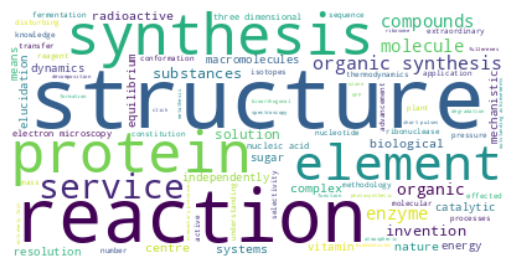

<class 'str'>


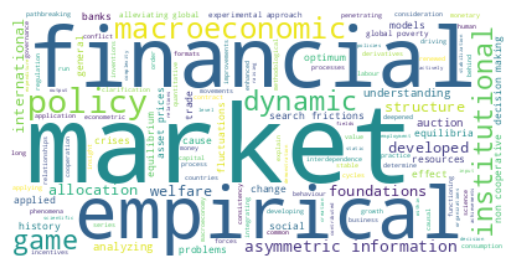

<class 'str'>


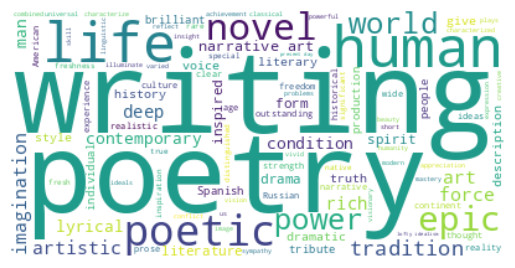

<class 'str'>


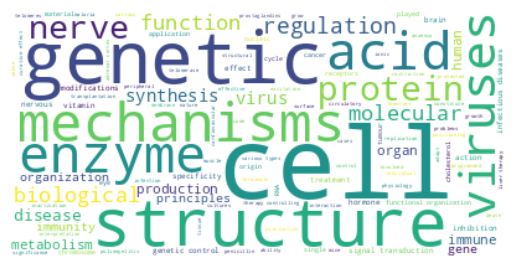

<class 'str'>


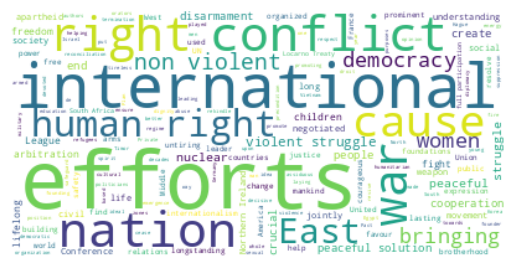

<class 'str'>


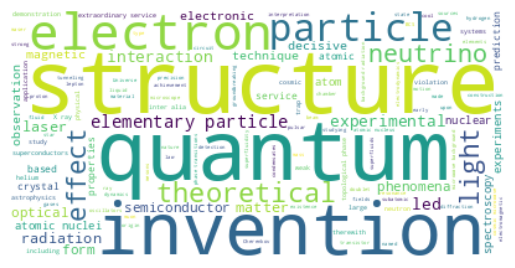

In [342]:
# concatenate the motivation text data of all rows based on category
result = research_topic.groupby('category')['motivation'].apply(lambda x: ' '.join(x)).reset_index()

# word cloud of chemistry, economics, literature, medicine, peace, physics
for index, row in result.iterrows():
    text = row['motivation']
    print(type(text))
    #text = result.motivation[0]
    # Create and generate a word cloud image:
    wordcloud = WordCloud(stopwords=all_stop_words,  background_color="white").generate(text)

    # Display the generated image:
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.show()

In [343]:
result['motivation'] = pd.Series(result['motivation'], dtype="string")

In [344]:
text = result.loc[result['category'] == 'Physics', 'motivation']
new_str = [str(x) for x in text][0]

In [345]:
new_str

'"in recognition of the extraordinary service they rendered by their researches into the influence of magnetism upon radiation phenomena" "in recognition of the extraordinary service they rendered by their researches into the influence of magnetism upon radiation phenomena" "in recognition of the extraordinary services he has rendered by his discovery of spontaneous radioactivity" "in recognition of the extraordinary services they have rendered by their joint researches on the radiation phenomena discovered by Professor Henri Becquerel" "for his investigations of the densities of the most important gases and for his discovery of argon in connection with these studies" "in recognition of the great merits of his theoretical and experimental investigations on the conduction of electricity by gases" "for his method of reproducing colours photographically based on the phenomenon of interference" "in recognition of their contributions to the development of wireless telegraphy" "for his work 

In [346]:
string_text = text.apply(str)
type(string_text)

pandas.core.series.Series

In [347]:
wordcloud = WordCloud(stopwords=all_stop_words,  background_color="white").generate(new_str)

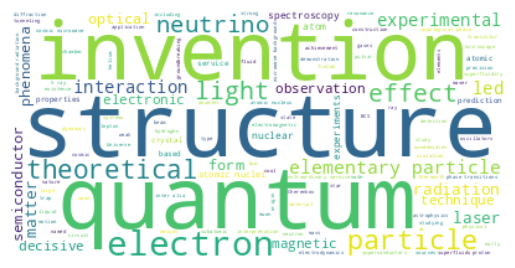

In [348]:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

In [349]:
filtered_physics = sharing_cat[sharing_cat['category'] == 'Physics'].copy()
collab_list=["Individual", "2 laureates", "3 laureates", "4 laureates"] 
filtered_physics['awarded_to'] = collab_list
filtered_physics.drop(['award_shared_with'], axis=1, inplace=True)

In [350]:

filtered_physics

Category  count   awarded_to
17  Physics     47   Individual
18  Physics     84  2 laureates
19  Physics     54  3 laureates
20  Physics     40  4 laureates

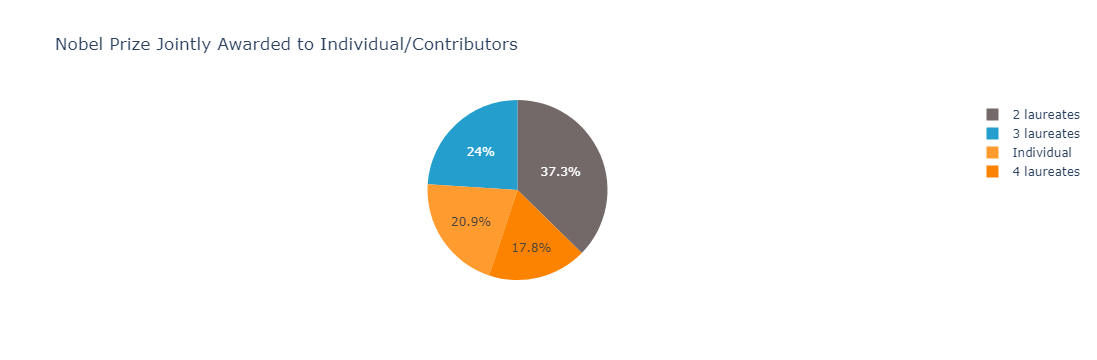

In [351]:
custom_purple_scale = ['#746969', '#249fcd', '#ff9b2f', '#fc8300', '#ffd92f']
fig = px.pie(filtered_physics, values='count', names='awarded_to', title='Nobel Prize Jointly Awarded to Individual/Contributors',
            color_discrete_sequence = custom_purple_scale)

values = filtered_physics['count']
hover_template = "<b>%{label}</b><br>Value: %{value}"
fig.update_traces(hovertemplate=hover_template)
fig.show()

# 4 laureates mean the award was shared among 3 people, with one person getting one half and the other 2 sharing the other half (1/2, 1/4, 1/4)

repeat laureates -  Marie Curie, John Bardeen, Linus Pauling and Frederick Sanger, Karl Barry Sharpless

#### 3.8 USA dominance 

In [486]:
countries_to_remove = ['Canada', 'Trinidad and Tobago', 'Costa Rica', 'Guatemala', 'Saint Lucia']

# Use not isin to delete rows where the 'Country' is not in the list to keep
Eu_Na = laureates_df[laureates_df['continent'].isin(['Europe', 'North America'])]
Eu_USA = Eu_Na[~Eu_Na['country_of_birth'].isin(countries_to_remove)]

In [487]:
Eu_USA.shape

(811, 21)

In [488]:
Eu_USA.columns

Index(['firstname', 'surname', 'DOB', 'DOD', 'country_of_birth',
       'city_of_birth', 'country_of_death', 'city_of_demise', 'gender',
       'year_of_award', 'Category', 'award_shared_with', 'motivation',
       'Institute', 'city', 'country', 'year_of_birth', 'month_of_birth',
       'awarded_age', 'institute', 'continent'],
      dtype='object')

In [491]:
Eu_USA

firstname                     surname         DOB         DOD  \
0             Hendrik A.                     Lorentz  1853-07-18  1928-02-04   
1                 Pieter                      Zeeman  1865-05-25  1943-10-09   
2                  Henri                   Becquerel  1852-12-15  1908-08-25   
3                 Pierre                       Curie  1859-05-15  1906-04-19   
4                   Lord                    Rayleigh  1842-11-12  1919-06-30   
5                   J.J.                     Thomson  1856-12-18  1940-08-30   
6                Gabriel                    Lippmann  1845-08-16  1921-07-13   
7              Guglielmo                     Marconi  1874-04-25  1937-07-20   
8       Johannes Diderik               van der Waals  1837-11-23  1923-03-08   
9                 Gustaf                       Dalén  1869-11-30  1937-12-09   
10                 Heike            Kamerlingh Onnes  1853-09-21  1926-02-21   
11                   Max                    von Laue  1879-10-09  1960-04-23   
12               William                       Bragg  1862-07-02  1942-03-12   
14        Charles Glover                      Barkla  1877-06-07  1944-10-23   
15              Johannes                       Stark  1874-04-15  1957-06-21   
16       Charles Edouard                   Guillaume  1861-02-15  1938-06-13   
17                Albert                    Einstein  1879-03-14  1955-04-18   
18                 Niels                        Bohr  1885-10-07  1962-11-18   
19             Robert A.                    Millikan  1868-03-22  1953-12-19   
20                 Manne                    Siegbahn  1886-12-03  1978-09-26   
21                 James                      Franck  1882-08-26  1964-05-21   
22                Gustav                       Hertz  1887-07-22  1975-10-30   
23         Jean Baptiste                      Perrin  1870-09-30  1942-04-17   
24             Arthur H.                     Compton  1892-09-10  1962-03-15   
25                C.T.R.                      Wilson  1869-02-14  1959-11-15   
26          Owen Willans                  Richardson  1879-04-26  1959-02-15   
27                 Louis                  de Broglie  1892-08-15  1987-03-19   
29                Werner                  Heisenberg  1901-12-05  1976-02-01   
30                 Erwin                 Schrödinger  1887-08-12  1961-01-04   
31             Paul A.M.                       Dirac  1902-08-08  1984-10-20   
32                 James                    Chadwick  1891-10-20  1974-07-24   
33             Victor F.                        Hess  1883-06-24  1964-12-17   
34               Carl D.                    Anderson  1905-09-03  1991-01-11   
35               Clinton                    Davisson  1881-10-22  1958-02-01   
36          George Paget                     Thomson  1892-05-03  1975-09-10   
37                Enrico                       Fermi  1901-09-29  1954-11-28   
38                Ernest                    Lawrence  1901-08-08  1958-08-27   
39              Wolfgang                       Pauli  1900-04-25  1958-12-15   
40              Percy W.                    Bridgman  1882-04-21  1961-08-20   
41             Edward V.                    Appleton  1892-09-06  1965-04-21   
42          Patrick M.S.                    Blackett  1897-11-18  1974-07-13   
44                 Cecil                      Powell  1903-12-05  1969-08-09   
45                  John                   Cockcroft  1897-05-27  1967-09-18   
46           Ernest T.S.                      Walton  1903-10-06  1995-06-25   
47                 Felix                       Bloch  1905-10-23  1983-09-10   
48                 E. M.                     Purcell  1912-08-30  1997-03-07   
49                 Frits                     Zernike  1888-07-16  1966-03-10   
50               Walther                       Bothe  1891-01-08  1957-02-08   
51             Willis E.                        Lamb  1913-07-12  2008-05-15   
52             

In [501]:
USA_dominance = Eu_USA.groupby(['continent', 'year_of_award']).size().reset_index(name="count")
USA_dominance 

continent  year_of_award  count
0           Europe           1901      6
1           Europe           1902      6
2           Europe           1903      7
3           Europe           1904      5
4           Europe           1905      5
5           Europe           1906      5
6           Europe           1907      5
7           Europe           1908      6
8           Europe           1909      7
9           Europe           1910      4
10          Europe           1911      6
11          Europe           1912      5
12          Europe           1913      4
13          Europe           1914      2
14          Europe           1915      3
15          Europe           1916      1
16          Europe           1917      3
17          Europe           1918      2
18          Europe           1919      3
19          Europe           1920      5
20          Europe           1921      5
21          Europe           1922      6
22          Europe           1923      3
23          Europe           1924      2
24          Europe           1925      5
25          Europe           1926      6
26          Europe           1927      6
27          Europe           1928      4
28          Europe           1929      6
29          Europe           1930      3
30          Europe           1931      4
31          Europe           1932      4
32          Europe           1933      4
33          Europe           1934      2
34          Europe           1935      5
35          Europe           1936      4
36          Europe           1937      6
37          Europe           1938      3
38          Europe           1939      4
39          Europe           1943      3
40          Europe           1944      3
41          Europe           1945      4
42          Europe           1946      1
43          Europe           1947      5
44          Europe           1948      3
45          Europe           1949      3
46          Europe           1950      5
47          Europe           1951      4
48          Europe           1952      6
49          Europe           1953      5
50          Europe           1954      2
51          Europe           1955      3
52          Europe           1956      6
53          Europe           1957      2
54          Europe           1958      6
55          Europe           1959      5
56          Europe           1960      1
57          Europe           1961      4
58          Europe           1962      3
59          Europe           1963      7
60          Europe           1964      4
61          Europe           1965      4
62          Europe           1966      3
63          Europe           1967      5
64          Europe           1968      2
65          Europe           1969      7
66          Europe           1970      6
67          Europe           1971      4
68          Europe           1972      3
69          Europe           1973     10
70          Europe           1974     10
71          Europe           1975      7
72          Europe           1976      2
73          Europe           1977      7
74          Europe           1978      6
75          Europe           1979      5
76          Europe           1980      3
77          Europe           1981      5
78          Europe           1982      5
79          Europe           1983      3
80          Europe           1984      6
81          Europe           1985      2
82          Europe           1986      6
83          Europe           1987      4
84          Europe           1988      6
85          Europe           1989      4
86          Europe           1990      1
87          Europe           1991      5
88          Europe           1992      1
89          Europe           1993      2
90          Europe           1994      4
91          Europe           1995      4
92          Europe           1996      4
93          Europe           1997      3
94          Europe           1998      6
95          Europe           1999      4
96          Europe           200

In [514]:
USA_dominance['cumsum'] = USA_dominance.groupby(['continent'])['count'].cumsum()
USA_dominance = USA_dominance.loc[USA_dominance['continent'] == 'North America']
USA_dominance.loc[USA_dominance['continent'].str.contains('North America', na=False), 'continent'] = 'USA'

C:\Users\shrid\AppData\Local\Temp\ipykernel_31732\1660833323.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



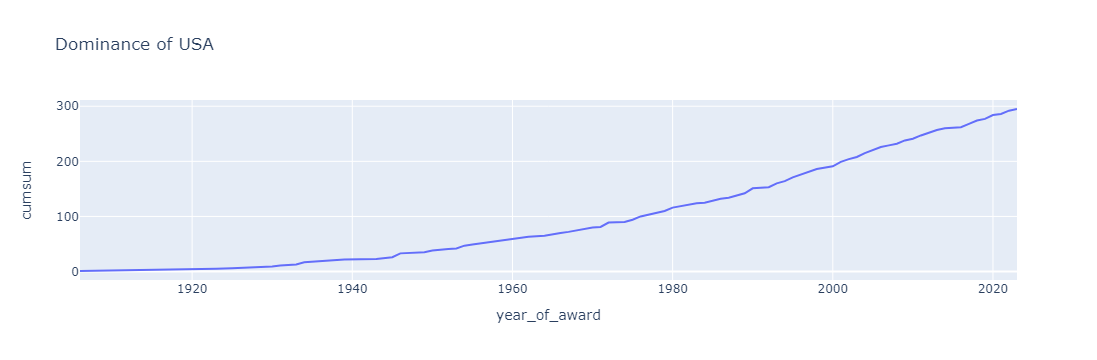

In [516]:
fig = px.line(USA_dominance, x="year_of_award", y="cumsum", title='Dominance of USA')
fig.show()

In [548]:
average_age_by_category = laureates_df.groupby('category')['awarded_age'].mean()
average_age_by_category

Category
Chemistry     59.128866
Economics     66.935484
Literature    64.991667
Medicine      58.696035
Peace         60.774775
Physics       57.262222
Name: awarded_age, dtype: float64

In [689]:
period_length = 10
start_year = 1900
end_year = 2031
final_end = end_year 

In [690]:
starts = np.arange(start_year, end_year, period_length).tolist()

year_range = end_year - start_year
modulo = year_range % period_length

if modulo == 0:
    final_start = end_year - period_length
else:
    final_start = end_year - 2
final_end = end_year 


tuples = [(start, start+period_length) for start in starts]
# We'll add the last period calculated earlier
tuples.append(tuple([final_start, final_end]))
bins = pd.IntervalIndex.from_tuples(tuples, closed='left')
print(bins)


original_labels = list(bins.astype(str))
new_labels = ['{} - {}'.format(b.strip('[)').split(', ')[0], int(b.strip('[)').split(', ')[1])-1) for b in original_labels]
label_dict = dict(zip(original_labels, new_labels))
labels = list(label_dict.values())
labels = labels[:-2]  
print(labels)

laureates_df['period'] = pd.cut(laureates_df['year_of_award'], bins=starts, labels=labels)

[1900,
 1910,
 1920,
 1930,
 1940,
 1950,
 1960,
 1970,
 1980,
 1990,
 2000,
 2010,
 2020,
 2030]

In [691]:
year_range = end_year - start_year
modulo = year_range % period_length
modulo

1

In [692]:
if modulo == 0:
    final_start = end_year - period_length
else:
    final_start = end_year - 2
final_end = end_year 

In [693]:
tuples = [(start, start+period_length) for start in starts]
# We'll add the last period calculated earlier
tuples.append(tuple([final_start, final_end]))
bins = pd.IntervalIndex.from_tuples(tuples, closed='left')
bins

IntervalIndex([[1900, 1910), [1910, 1920), [1920, 1930), [1930, 1940), [1940, 1950) ... [2000, 2010), [2010, 2020), [2020, 2030), [2030, 2040), [2029, 2031)], dtype='interval[int64, left]')

In [696]:
original_labels = list(bins.astype(str))
new_labels = ['{} - {}'.format(b.strip('[)').split(', ')[0], int(b.strip('[)').split(', ')[1])-1) for b in original_labels]
label_dict = dict(zip(original_labels, new_labels))
labels = list(label_dict.values())
labels = labels[:-2]  
labels

['1900 - 1909',
 '1910 - 1919',
 '1920 - 1929',
 '1930 - 1939',
 '1940 - 1949',
 '1950 - 1959',
 '1960 - 1969',
 '1970 - 1979',
 '1980 - 1989',
 '1990 - 1999',
 '2000 - 2009',
 '2010 - 2019',
 '2020 - 2029']

In [697]:
laureates_df['period'] = pd.cut(laureates_df['year_of_award'], bins=starts, labels=labels)

In [705]:
laureates_df.columns

Index(['firstname', 'surname', 'DOB', 'DOD', 'country_of_birth',
       'city_of_birth', 'country_of_death', 'city_of_demise', 'gender',
       'year_of_award', 'Category', 'award_shared_with', 'motivation',
       'Institute', 'city', 'country', 'year_of_birth', 'month_of_birth',
       'awarded_age', 'institute', 'continent', 'period'],
      dtype='object')

In [753]:
avg_age = laureates_df.groupby(['period', 'category'])['awarded_age'].mean().reset_index()


In [711]:
avg_age

period    Category  awarded_age
0   1900 - 1909   Chemistry    52.200000
1   1900 - 1909   Economics          NaN
2   1900 - 1909  Literature    66.272727
3   1900 - 1909    Medicine    56.083333
4   1900 - 1909       Peace    67.307692
5   1900 - 1909     Physics    50.928571
6   1910 - 1919   Chemistry    48.125000
7   1910 - 1919   Economics          NaN
8   1910 - 1919  Literature    56.888889
9   1910 - 1919    Medicine    47.333333
10  1910 - 1919       Peace    63.000000
11  1910 - 1919     Physics    46.700000
12  1920 - 1929   Chemistry    51.600000
13  1920 - 1929   Economics          NaN
14  1920 - 1929  Literature    58.500000
15  1920 - 1929    Medicine    55.363636
16  1920 - 1929       Peace    63.636364
17  1920 - 1929     Physics    44.166667
18  1930 - 1939   Chemistry    45.750000
19  1930 - 1939   Economics          NaN
20  1930 - 1939  Literature    57.875000
21  1930 - 1939    Medicine    54.153846
22  1930 - 1939       Peace    64.142857
23  1930 - 1939     Physics    41.200000
24  1940 - 1949   Chemistry    55.636364
25  1940 - 1949   Economics          NaN
26  1940 - 1949  Literature    66.285714
27  1940 - 1949    Medicine    56.176471
28  1940 - 1949       Peace    69.800000
29  1940 - 1949     Physics    50.625000
30  1950 - 1959   Chemistry    51.692308
31  1950 - 1959   Economics          NaN
32  1950 - 1959  Literature    63.200000
33  1950 - 1959    Medicine    51.105263
34  1950 - 1959       Peace    66.000000
35  1950 - 1959     Physics    49.150000
36  1960 - 1969   Chemistry    56.600000
37  1960 - 1969   Economics    65.000000
38  1960 - 1969  Literature    65.090909
39  1960 - 1969    Medicine    55.807692
40  1960 - 1969       Peace    57.800000
41  1960 - 1969     Physics    52.666667
42  1970 - 1979   Chemistry    60.529412
43  1970 - 1979   Economics    67.333333
44  1970 - 1979  Literature    68.818182
45  1970 - 1979    Medicine    57.480000
46  1970 - 1979       Peace    56.250000
47  1970 - 1979     Physics    52.840000
48  1980 - 1989   Chemistry    56.789474
49  1980 - 1989   Economics    67.083333
50  1980 - 1989  Literature    68.300000
51  1980 - 1989    Medicine    60.772727
52  1980 - 1989       Peace    57.750000
53  1980 - 1989     Physics    60.260870
54  1990 - 1999   Chemistry    63.750000
55  1990 - 1999   Economics    65.375000
56  1990 - 1999  Literature    65.900000
57  1990 - 1999    Medicine    61.476190
58  1990 - 1999       Peace    59.857143
59  1990 - 1999     Physics    61.590909
60  2000 - 2009   Chemistry    66.280000
61  2000 - 2009   Economics    67.666667
62  2000 - 2009  Literature    67.800000
63  2000 - 2009    Medicine    63.083333
64  2000 - 2009       Peace    62.300000
65  2000 - 2009     Physics    66.185185
66  2010 - 2019   Chemistry    69.038462
67  2010 - 2019   Economics    67.473684
68  2010 - 2019  Literature    70.200000
69  2010 - 2019    Medicine    68.423077
70  2010 - 2019       Peace    46.333333
71  2010 - 2019     Physics    69.777778
72  2020 - 2029   Chemistry    66.375000
73  2020 - 2029   Economics    66.571429
74  2020 - 2029  Literature    73.000000
75  2020 - 2029    Medicine    63.800000
76  2020 - 2029       Peace    57.250000
77  2020 - 2029     Physics    77.000000

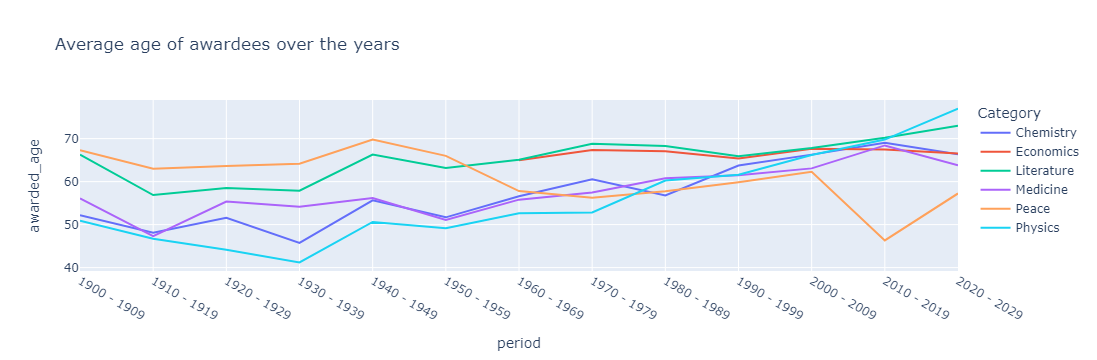

In [712]:
fig = px.line(avg_age, x="period", y="awarded_age", color='Category', title='Average age of awardees over the years')
fig.show()

In [754]:
laureates_df.columns

Index(['firstname', 'surname', 'DOB', 'DOD', 'country_of_birth',
       'city_of_birth', 'country_of_death', 'city_of_demise', 'gender',
       'year_of_award', 'category', 'award_shared_with', 'motivation',
       'Institute', 'city', 'country', 'year_of_birth', 'month_of_birth',
       'awarded_age', 'institute', 'continent', 'period'],
      dtype='object')

In [760]:
top10countries

firstname                     surname         DOB         DOD  \
2                  Henri                   Becquerel  1852-12-15  1908-08-25   
3                 Pierre                       Curie  1859-05-15  1906-04-19   
4                   Lord                    Rayleigh  1842-11-12  1919-06-30   
5                   J.J.                     Thomson  1856-12-18  1940-08-30   
7              Guglielmo                     Marconi  1874-04-25  1937-07-20   
9                 Gustaf                       Dalén  1869-11-30  1937-12-09   
11                   Max                    von Laue  1879-10-09  1960-04-23   
12               William                       Bragg  1862-07-02  1942-03-12   
14        Charles Glover                      Barkla  1877-06-07  1944-10-23   
15              Johannes                       Stark  1874-04-15  1957-06-21   
17                Albert                    Einstein  1879-03-14  1955-04-18   
19             Robert A.                    Millikan  1868-03-22  1953-12-19   
20                 Manne                    Siegbahn  1886-12-03  1978-09-26   
21                 James                      Franck  1882-08-26  1964-05-21   
22                Gustav                       Hertz  1887-07-22  1975-10-30   
23         Jean Baptiste                      Perrin  1870-09-30  1942-04-17   
24             Arthur H.                     Compton  1892-09-10  1962-03-15   
25                C.T.R.                      Wilson  1869-02-14  1959-11-15   
26          Owen Willans                  Richardson  1879-04-26  1959-02-15   
27                 Louis                  de Broglie  1892-08-15  1987-03-19   
29                Werner                  Heisenberg  1901-12-05  1976-02-01   
31             Paul A.M.                       Dirac  1902-08-08  1984-10-20   
32                 James                    Chadwick  1891-10-20  1974-07-24   
34               Carl D.                    Anderson  1905-09-03  1991-01-11   
35               Clinton                    Davisson  1881-10-22  1958-02-01   
36          George Paget                     Thomson  1892-05-03  1975-09-10   
37                Enrico                       Fermi  1901-09-29  1954-11-28   
38                Ernest                    Lawrence  1901-08-08  1958-08-27   
40              Percy W.                    Bridgman  1882-04-21  1961-08-20   
41             Edward V.                    Appleton  1892-09-06  1965-04-21   
42          Patrick M.S.                    Blackett  1897-11-18  1974-07-13   
43                Hideki                      Yukawa  1907-01-23  1981-09-08   
44                 Cecil                      Powell  1903-12-05  1969-08-09   
45                  John                   Cockcroft  1897-05-27  1967-09-18   
48                 E. M.                     Purcell  1912-08-30  1997-03-07   
50               Walther                       Bothe  1891-01-08  1957-02-08   
51             Willis E.                        Lamb  1913-07-12  2008-05-15   
52              Polykarp                       Kusch  1911-01-26  1993-03-20   
53            William B.                    Shockley  1910-02-13  1989-08-12   
54                  John                     Bardeen  1908-05-23  1991-01-30   
55                  John                     Bardeen  1908-05-23  1991-01-30   
59              Pavel A.                   Cherenkov  1904-07-28  1990-01-06   
60               Igor Y.                        Tamm  1895-07-08  1971-04-12   
61                Emilio                       Segrè  1905-02-01  1989-04-22   
62                  Owen                 Chamberlain  1920-07-10  2006-02-28   
63             Donald A.                      Glaser  1926-09-21  2013-02-28   
64                Robert                  Hofstadter  1915-02-05  1990-11-17   
65                Rudolf                   Mössbauer  1929-01-31  2011-09-14   
66            J. Hans D.                      Jensen  1907-06-25  1973-02-11   
67            C

In [775]:
#"Poland", "Russia", "Japan", "Canada", "Italy"
top10countries = laureates_df[laureates_df['country_of_birth'].isin(["USA", "United Kingdom", "Germany", "France", "Sweden"])]
usa_dominance = top10countries.groupby(['country_of_birth', 'period']).size().reset_index(name = "count")
usa_dominance['cumsum'] =  usa_dominance.groupby(['country_of_birth'])['count'].cumsum()
usa_dominance

country_of_birth       period  count  cumsum
0            France  1900 - 1909      9       9
1            France  1910 - 1919      7      16
2            France  1920 - 1929      7      23
3            France  1930 - 1939      3      26
4            France  1940 - 1949      1      27
5            France  1950 - 1959      5      32
6            France  1960 - 1969      9      41
7            France  1970 - 1979      3      44
8            France  1980 - 1989      3      47
9            France  1990 - 1999      1      48
10           France  2000 - 2009      4      52
11           France  2010 - 2019      6      58
12           France  2020 - 2029      4      62
13          Germany  1900 - 1909     10      10
14          Germany  1910 - 1919      4      14
15          Germany  1920 - 1929     11      25
16          Germany  1930 - 1939      7      32
17          Germany  1940 - 1949      4      36
18          Germany  1950 - 1959      5      41
19          Germany  1960 - 1969      8      49
20          Germany  1970 - 1979      7      56
21          Germany  1980 - 1989     11      67
22          Germany  1990 - 1999      5      72
23          Germany  2000 - 2009      6      78
24          Germany  2010 - 2019      5      83
25          Germany  2020 - 2029      2      85
26           Sweden  1900 - 1909      3       3
27           Sweden  1910 - 1919      3       6
28           Sweden  1920 - 1929      4      10
29           Sweden  1930 - 1939      1      11
30           Sweden  1940 - 1949      1      12
31           Sweden  1950 - 1959      2      14
32           Sweden  1960 - 1969      3      17
33           Sweden  1970 - 1979      4      21
34           Sweden  1980 - 1989      5      26
35           Sweden  1990 - 1999      1      27
36           Sweden  2000 - 2009      0      27
37           Sweden  2010 - 2019      2      29
38           Sweden  2020 - 2029      1      30
39              USA  1900 - 1909      1       1
40              USA  1910 - 1919      3       4
41              USA  1920 - 1929      5       9
42              USA  1930 - 1939     13      22
43              USA  1940 - 1949     16      38
44              USA  1950 - 1959     20      58
45              USA  1960 - 1969     22      80
46              USA  1970 - 1979     36     116
47              USA  1980 - 1989     33     149
48              USA  1990 - 1999     39     188
49              USA  2000 - 2009     50     238
50              USA  2010 - 2019     43     281
51              USA  2020 - 2029     11     292
52   United Kingdom  1900 - 1909      4       4
53   United Kingdom  1910 - 1919      2       6
54   United Kingdom  1920 - 1929      9      15
55   United Kingdom  1930 - 1939     11      26
56   United Kingdom  1940 - 1949      7      33
57   United Kingdom  1950 - 1959      9      42
58   United Kingdom  1960 - 1969      7      49
59   United Kingdom  1970 - 1979     16      65
60   United Kingdom  1980 - 1989      5      70
61   United Kingdom  1990 - 1999     10      80
62   United Kingdom  2000 - 2009     11      91
63   United Kingdom  2010 - 2019     14     105
64   United Kingdom  2020 - 2029      1     106

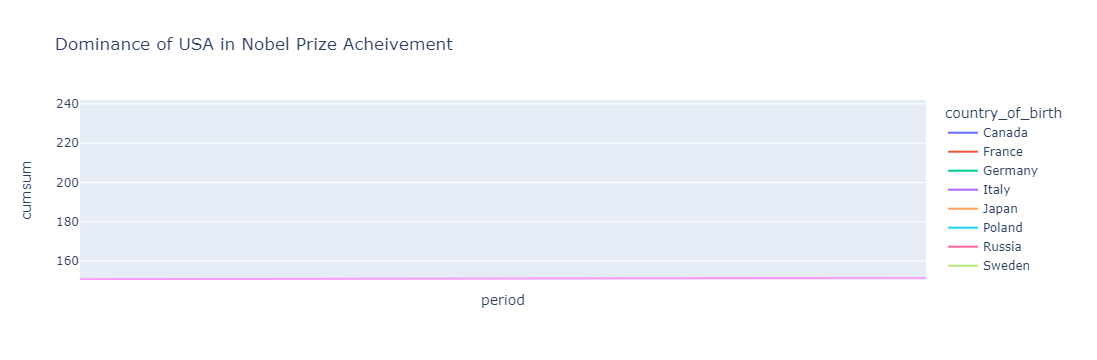

In [776]:
figure = px.line(df2, x="period", y="cumsum", color='country_of_birth', title='Dominance of USA in Nobel Prize Acheivement')
figure.show()